# Creating a classifier to diifferentiate between a leaf and not a leaf

In [1]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_size = 256
batch_size = 32
channels = 3

In [3]:
#importing data
df = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32

)

Found 6114 files belonging to 2 classes.


In [27]:
#assigning classes
class_names = df.class_names

In [28]:
class_names

['leaf', 'not leaf']

In [1]:
#Visualizing data

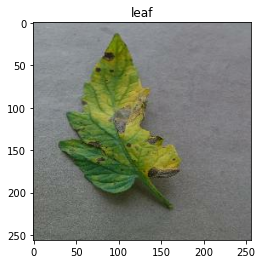

In [5]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    #plt.axis("off")

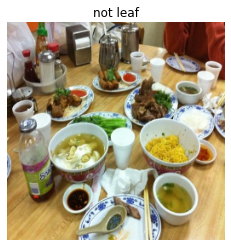

In [6]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[5].numpy().astype("uint8"))
    plt.title(class_names[label_batch[5]])
    plt.axis("off")

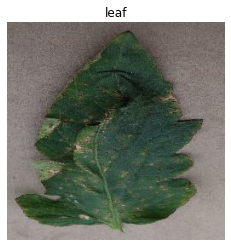

In [7]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

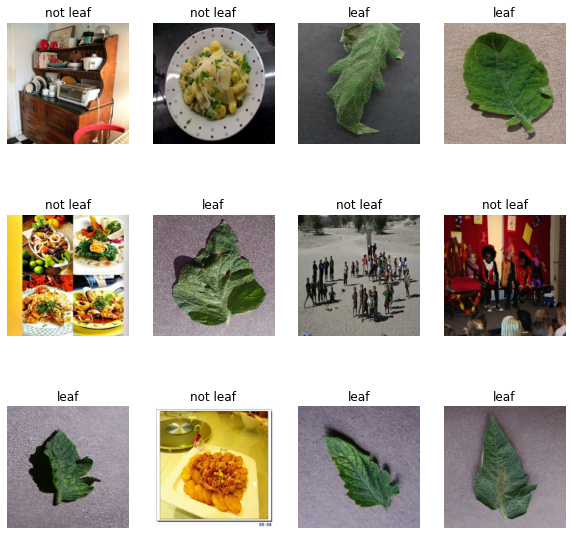

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
#Splitting the data in train, test and validation
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.1,test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [11]:
len(val_ds)

19

In [12]:
len(test_ds)

20

In [13]:
len(train_ds)

153

In [2]:
#Modelling

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape = (batch_size,image_size,image_size, channels)
n_classes = 2
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3),activation = "relu",input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = "relu"),
    layers.Dense(n_classes, activation = "softmax")
])
model.build(input_shape = (32,256,256,3))

In [18]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=8,
    restore_best_weights=False,
)

In [3]:
#Training

In [20]:
#storing our results in history to later plot our loss
epochs = 10
history = model.fit(
    train_ds,
    epochs = epochs,
    #steps_per_epoch = steps_per_epoch,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds,
    #callbacks = [early_stopping]
)


Epoch 1/10
153/153 [==============================] - 1266s 8s/step - loss: 0.1856 - accuracy: 0.9250 - val_loss: 0.1017 - val_accuracy: 0.9533
Epoch 2/10
153/153 [==============================] - 950s 6s/step - loss: 0.1124 - accuracy: 0.9583 - val_loss: 0.1051 - val_accuracy: 0.9516
Epoch 3/10
153/153 [==============================] - 767s 5s/step - loss: 0.1302 - accuracy: 0.9571 - val_loss: 0.0932 - val_accuracy: 0.9723
Epoch 4/10
153/153 [==============================] - 757s 5s/step - loss: 0.0706 - accuracy: 0.9753 - val_loss: 0.0647 - val_accuracy: 0.9758
Epoch 5/10
153/153 [==============================] - 828s 5s/step - loss: 0.0732 - accuracy: 0.9761 - val_loss: 0.1306 - val_accuracy: 0.9412
Epoch 6/10
153/153 [==============================] - 901s 6s/step - loss: 0.0679 - accuracy: 0.9781 - val_loss: 0.0693 - val_accuracy: 0.9723
Epoch 7/10
153/153 [==============================] - 826s 5s/step - loss: 0.0478 - accuracy: 0.9833 - val_loss: 0.0509 - val_accuracy: 0.979

In [21]:
model.evaluate(test_ds)

20/20 [==============================] - 230s 1s/step - loss: 0.0643 - accuracy: 0.9766


[0.06432946026325226, 0.9765625]

In [4]:
#Visualizing the training report

In [22]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation accuracy')

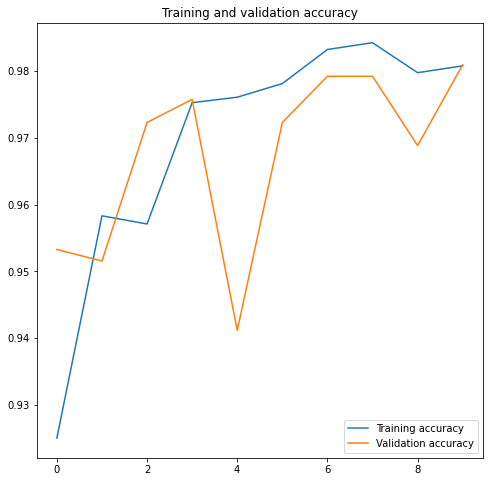

In [23]:
epochs = epochs
plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = "Training accuracy")
plt.plot(range(epochs), val_acc, label = "Validation accuracy")
plt.legend(loc ="lower right")
plt.title("Training and validation accuracy")

In [ ]:
#Testing 

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

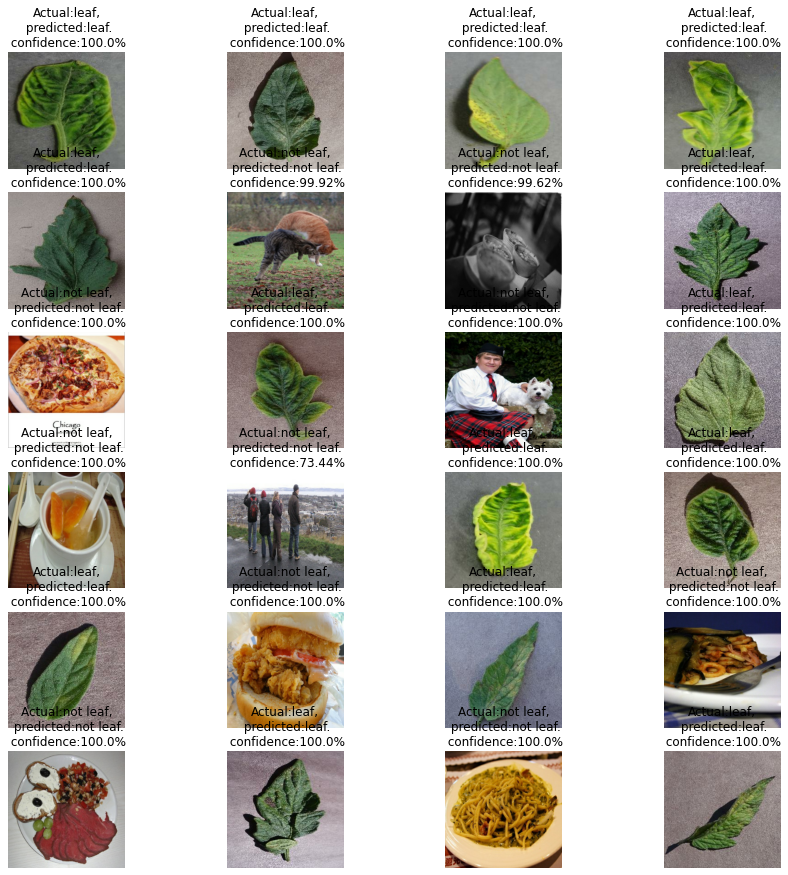

In [25]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(24):
        ax = plt.subplot(6,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n predicted:{predicted_class}.\n confidence:{confidence}%")
        
        plt.axis("off")

In [26]:
model.save(f"./models/1")

INFO:tensorflow:Assets written to: ./models/1\assets
